# MadMiner : Queue of Miners 

This file will be used to quickly generate lots of events.  

## 0. Setup Environment

In [1]:
#Set right path to MadMiner
import sys
import os
delphes_src_path = "/Users/felixkling/Documents/GitHub/delphesminer"
sys.path.append(delphes_src_path)
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

#Import MadMiner
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.tools.plots import plot_2d_morphing_basis
from delphesprocessor.delphesprocessor import DelphesProcessor

#Set Path to MG5 directory
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Define parameter space

In [2]:
#Initialize GoldMiner
miner = GoldMine()

#Define Parameter Space
miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)

15:55  
15:55  ------------------------------------------------------------
15:55  |                                                          |
15:55  |  MadMiner                                                |
15:55  |                                                          |
15:55  |  Version from July 19, 2018                              |
15:55  |                                                          |
15:55  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:55  |                                                          |
15:55  ------------------------------------------------------------
15:55  
15:55  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:55  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))


## 2. Define benchmark points (evaluation points for |M|^2)

I now define all benchmarks by hand - to be able to regenerate more events with same benchmarks later

15:55  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
15:55  Added benchmark bsm1: CWL2 = 4.00, CPWL2 = 0.00e+00)
15:55  Added benchmark bsm2: CWL2 = -7.64e+00, CPWL2 = -7.01e+00)
15:55  Added benchmark bsm3: CWL2 = 3.29, CPWL2 = -9.86e+00)
15:55  Added benchmark bsm4: CWL2 = -8.68e+00, CPWL2 = 6.87)
15:55  Added benchmark bsm5: CWL2 = 8.08, CPWL2 = 9.50)
15:55  Optimizing basis for morphing
15:55  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
15:55  Added benchmark bsm1: CWL2 = 4.00, CPWL2 = 0.00e+00)
15:55  Added benchmark bsm2: CWL2 = -7.64e+00, CPWL2 = -7.01e+00)
15:55  Added benchmark bsm3: CWL2 = 3.29, CPWL2 = -9.86e+00)
15:55  Added benchmark bsm4: CWL2 = -8.68e+00, CPWL2 = 6.87)
15:55  Added benchmark bsm5: CWL2 = 8.08, CPWL2 = 9.50)
15:55  Saving setup (including morphing) to data/madminer_example.h5


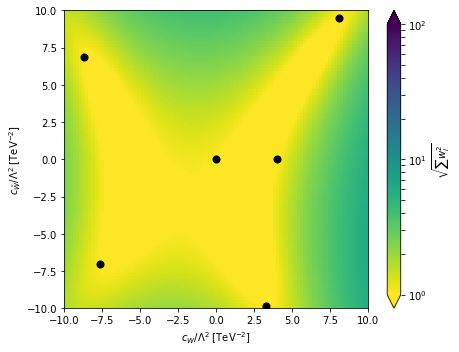

In [3]:
#Add Benchmark by hand
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':4., 'CPWL2':0.},
    'bsm1'
)
miner.add_benchmark(
    {'CWL2':-7.64, 'CPWL2':-7.01},
    'bsm2'
)
miner.add_benchmark(
    {'CWL2':3.29, 'CPWL2':-9.86},
    'bsm3'
)
miner.add_benchmark(
    {'CWL2':-8.68, 'CPWL2':6.87},
    'bsm4'
)
miner.add_benchmark(
    {'CWL2':8.08, 'CPWL2':9.50},
    'bsm5'
)

#Set Benchmarks
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

#Plot Benchmarks
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-10.,10),
    yrange=(-10.,10.)
)

#Save Settings
miner.save('data/madminer_example.h5')

## 3. Save settings and run MadGraph + Delphes

Run everything

In [5]:
#Set number of runs
nruns = 2

for counter in range (1, nruns+1):
    #Run MG5/Reweight/Pythia
    miner.run(mg_directory=mg_dir,
              proc_card_file='cards/proc_card.dat',
              param_card_template_file='cards/param_card_template.dat',
              reweight_card_template_file='cards/reweight_card_template.dat',
              run_card_file='cards/run_card.dat',
              pythia8_card_file='cards/pythia8_card.dat',
              sample_benchmark='sm',
              initial_command='source ~/.bashrc'
          )
    
    #Initialize DelphesProcessor
    dm = DelphesProcessor()
    
    #Set hepmc file 
    dm.add_hepmc_sample('MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz')
    
    #Run Delphes
    dm.run_delphes(delphes_directory=mg_dir + '/Delphes',
               delphes_card='cards/delphes_card.dat',
               initial_command='source ~/.bashrc')
    
    #Define observables 
    dm.add_observable('pt_e1', 'e[0].pt', required=True)
    dm.add_observable('pt_mu1', 'mu[0].pt', required=True)
    dm.add_observable('delta_eta_ll', 'abs(e[0].eta - mu[0].eta)', required=True)
    dm.add_observable('delta_phi_ll', 'abs(e[0].phi() - mu[0].phi())', required=True)
    
    #Extract all these observables from the Delphes ROOT file generated before:
    dm.analyse_delphes_samples()
    
    #The values of the observables and the weights are then saved in the HDF5 file
    dm.save('data/madminer_example_with_data_run'+`counter`+'.h5', 'data/madminer_example.h5')

15:59  Generating MadGraph process folder from cards/proc_card.dat at ./MG_process
15:59  Creating param and reweight cards in ./MG_process
15:59  Starting MadGraph and Pythia in ./MG_process
15:59  
15:59  ------------------------------------------------------------
15:59  |                                                          |
15:59  |  DelphesProcessor                                        |
15:59  |                                                          |
15:59  |  Version from July 19, 2018                              |
15:59  |                                                          |
15:59  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:59  |                                                          |
15:59  ------------------------------------------------------------
15:59  
15:59  Hi! How are you today?
15:59  Adding HepMC sample at MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz
15:59  Running Delphes at /Users/felixkling/work/MG5_aMC_v2_6_2/D

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In [7]:
combine_and_shuffle(
    ['data/madminer_example_with_data_run0.h5','data/madminer_example_with_data_run1.h5'],
    'data/madminer_example_shuffled.h5'
)

16:03  
16:03  ------------------------------------------------------------
16:03  |                                                          |
16:03  |  MadMiner                                                |
16:03  |                                                          |
16:03  |  Version from July 19, 2018                              |
16:03  |                                                          |
16:03  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:03  |                                                          |
16:03  ------------------------------------------------------------
16:03  
16:03  Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
16:03  Copying setup from data/madminer_example_with_data_run0.h5 to data/madminer_example_shuffle